# **Large-Scale Kinship Recognition Data Challenge: Kinship Verification STARTER NOTEBOOK**

We provide framework code to get you started on the competition. The notebook is broken up into three main sections. 
1. Data Loading & Visualizing
2. Data Generator & Model Building
3. Training & Testing Model

We have done the majority of the heavy lifting by making the data easily and readily accessible through Google Drive. Furthermore, we have made the task easier by creating a dataloader and fully trained end-to-end model that predicts a binary label (0 or 1) denoting whether two faces share a kinship relation. 


David Heagy (dh2868), 
Alexander Lieberman (al4008)

NOTE : Will need to change paths for running

**WARNING: IF YOU HAVE NOT DONE SO**

Change to GPU:

Runtime --> Change Runtime Type --> GPU

Mount to Google Drive

Install Libraries

In [ ]:
%%capture
!pip install keras_vggface
!pip install keras_applications
!pip install keras-facenet
!pip install keras==2.2.4

In [203]:
import os
import tensorflow as tf
from tensorflow import keras
from collections import defaultdict
from glob import glob
from random import choice, sample

import cv2
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model

from tensorflow.keras.optimizers import Adam

from keras_vggface.utils import preprocess_input

from keras_vggface.vggface import VGGFace
from keras_facenet import FaceNet, inception_resnet_v1

train_relationships.csv contains pairs of image paths which are positive samples (related to each other).

train-faces contains the images for training itself.

In [205]:
# Modify paths as per your method of saving them
train_file_path = r"<REPLACE-PATH>\Kinship Recognition Starter dh2868_al4008\train_ds.csv"
train_folders_path = "<REPLACE-PATH>\\Kinship Recognition Starter dh2868_al4008\\train\\train-faces\\"
# All images belonging to families F09** will be used to create the validation set while training the model
# For final submission, you can add these to the training data as well
val_famillies = "F05"

In [206]:
all_images = glob(train_folders_path + r"*\*\*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)

ppl = [x.split("\\")[-3] + "\\" + x.split("\\")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("\\")[-3] + "\\" + x.split("\\")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("\\")[-3] + "\\" + x.split("\\")[-2]].append(x)
    


In [208]:
import pandas as pd
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values, relationships.relationship.values))
relationships = [("\\".join(x[0].split("/")),"\\".join(x[1].split("/")),x[2]) for x in relationships if "\\".join(x[0][:10].split("/")) in ppl and "\\".join(x[1][:10].split("/")) in ppl]

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [209]:
from keras.preprocessing import image
def read_img(path):
    img = image.load_img(path, target_size=(224, 224))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)
# preprocess code for facenet taken from this link : 
# https://medium.com/@sritejabanisetti21/kinship-recognition-through-a-double-siamese-network-b2edacf39aee
import random
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y


def read_img_vgg(path):
    img = image.load_img(path, target_size=(224, 224))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

def read_img_fn(path):
    img = image.load_img(path, target_size=(160, 160))
    img = np.array(img).astype(np.float)
    return prewhiten(img)

def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size)
        
        # All the samples are taken from train_ds.csv, labels are in the labels column
        labels = []
        for tup in batch_tuples:
            labels.append(tup[2])

        X1 = [x[0] for x in batch_tuples]
        X1 = np.array([read_img(train_folders_path + x) for x in X1])

        X2 = [x[1] for x in batch_tuples]
        X2 = np.array([read_img(train_folders_path + x) for x in X2])

        yield [X1, X2], np.array(labels)
        
def gen2(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size)
        
        # All the samples are taken from train_ds.csv, labels are in the labels column
        labels = []
        for tup in batch_tuples:
            labels.append(tup[2])

        X1 = [x[0] for x in batch_tuples]
        X1_fn = np.array([read_img_fn(train_folders_path + x) for x in X1])
        X1_vgg = np.array([read_img_vgg(train_folders_path + x) for x in X1])


        X2 = [x[1] for x in batch_tuples]
        X2_fn = np.array([read_img_fn(train_folders_path + x) for x in X2])
        X2_vgg = np.array([read_img_vgg(train_folders_path + x) for x in X2])
        yield [X1_vgg, X2_vgg, X1_fn,X2_fn], np.array(labels)

In [210]:
### new work
from tensorflow import keras
def model1():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))
    model_seq = tf.keras.models.Sequential([input_1, input_2])

    vgg_model = tf.keras.applications.vgg16.VGG16()
    for layer in vgg_model.layers[0:-1]:
        model_seq.add(layer)
    for layer in model_seq.layers:
        layer.trainable = False
    model_seq.add(Dense(1, activation="sigmoid"))
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optim = keras.optimizers.Adam(lr = .001)
    metrics=["accuracy"]
    model_seq.compile(optimizer=optim, loss = loss, metrics=metrics)
    return model_seq


In [211]:
from tensorflow.keras.layers import Conv2D, Flatten, Lambda, Reshape,Add, Lambda, Subtract, Multiply, Average,Reshape
from tensorflow.keras.applications import resnet
from tensorflow import keras

# THIS MODEL HAD THE HIGHEST VAL ACCURACY : .596

def model2():
    #vgg
    input_1_vgg = Input(shape=(224, 224, 3))
    input_2_vgg = Input(shape=(224, 224, 3))
    #facenet
    input_1_fn = Input(shape=(160,160,3))
    input_2_fn = Input(shape=(160,160,3))
    vgg_model = VGGFace(model="senet50", include_top=False)
    facenet_path = r"<REPLACE-PATH>\Kinship Recognition Starter dh2868_al4008\facenet_keras.h5"
    facenet_model = load_model(facenet_path)
    for x in vgg_model.layers[:-1]:
        x.trainable = False
    for x in facenet_model.layers:
        x.trainable = False
    x1 = vgg_model(input_1_vgg)
    x2 = vgg_model(input_2_vgg)
    x3 = facenet_model(input_1_fn)
    x4 = facenet_model(input_2_fn)
    x1 = BatchNormalization()(x1)
    
    
    x2 = BatchNormalization()(x2)


    
    x3 = BatchNormalization()(x3)
    
    x4 = BatchNormalization()(x4)
   

    fn1 = Reshape((1,1,128))(x3)
    fn2 = Reshape((1,1,128))(x4)

    gmax_fn1 = Concatenate(axis=-1)([GlobalMaxPool2D()(fn1),GlobalAvgPool2D()(fn1) ])
    gmax_fn2 = Concatenate(axis=-1)([GlobalMaxPool2D()(fn2),GlobalAvgPool2D()(fn2) ])
    vgg_add = Add()([x1, x2])
    vgg_sub = Subtract()([x1, x2])
    vgg_mul = Multiply()([x1, x2])
    vgg_avg = Average()([x1, x2])
#     vgg_sub_sqd = keras.layers.Lambda(lambda x: (x[0]-x[1])**2)([x1,x2]) #https://stackoverflow.com/questions/47149675/keras-lambda-layer-for-l2-norm
#     vgg_sqd_sub = keras.layers.Lambda(lambda x: (x[0]**2-x[1]**2))([x1,x2]) #https://stackoverflow.com/questions/47149675/keras-lambda-layer-for-l2-norm
    fn_add = Add()([gmax_fn1, gmax_fn2])
    fn_sub = Subtract()([gmax_fn1, gmax_fn2])
    fn_mul = Multiply()([gmax_fn1, gmax_fn2])
    fn_avg = Average()([gmax_fn1, gmax_fn2])
#     fn_sub_sqd = keras.layers.Lambda(lambda x: (x[0]-x[1])**2)([gmax_fn1, gmax_fn2]) #https://stackoverflow.com/questions/47149675/keras-lambda-layer-for-l2-norm
#     fn_sqd_sub = keras.layers.Lambda(lambda x: (x[0]**2-x[1]**2))([gmax_fn1, gmax_fn2])

#     conv_vgg_add = Conv2D(128, [1,1], )(vgg_add)
#     conv_vgg_sub = Conv2D(128, [1,1], )(vgg_sub)
#     conv_vgg_mul = Conv2D(128, [1,1], )(vgg_mul)
#     conv_vgg_avg = Conv2D(128, [1,1], )(vgg_avg)
#     conv_vgg_sub_sqd  = Conv2D(128, [1,1], )(vgg_sub_sqd )
#     conv_avg_sqd_sub = Conv2D(128, [1,1], )(vgg_sqd_sub)

    all_f = Concatenate(axis=-1)([Flatten()(vgg_add),  (fn_add) ,
                                  Flatten()(vgg_sub), (fn_sub),
                                  Flatten()(vgg_mul), (fn_mul),
                                  Flatten()(vgg_avg), (fn_avg),
#                                   Flatten()(conv_vgg_sub_sqd), (fn_sub_sqd),
#                                   Flatten()(conv_avg_sqd_sub), (fn_sqd_sub)
                                  
                         ])
    x = Dense(100, activation="relu")(all_f)
    x = Dropout(0.01)(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(all_f)
    x = Dropout(0.01)(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1_vgg, input_2_vgg, input_1_fn, input_2_fn], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [212]:
def model3():
    #vgg
    input_1_vgg = Input(shape=(224, 224, 3))
    input_2_vgg = Input(shape=(224, 224, 3))
    #facenet
    input_1_fn = Input(shape=(160,160,3))
    input_2_fn = Input(shape=(160,160,3))

    vgg_model_res = VGGFace(model="resnet50", include_top=False)
    vgg_model_sen = VGGFace(model="senet50", include_top=False)
    facenet_path = r"<REPLACE-PATH>\Kinship Recognition Starter dh2868_al4008\facenet_keras.h5"

    facenet_model = load_model(facenet_path)
    for x in vgg_model_res.layers[:-1]:
        x.trainable = False
    for x in vgg_model_sen.layers[:-1]:
        x.trainable = False
    for x in facenet_model.layers:
        x.trainable = False
    x1r = vgg_model_res(input_1_vgg)
    x2r = vgg_model_res(input_2_vgg)
    x1s = vgg_model_sen(input_1_vgg)
    x2s = vgg_model_sen(input_2_vgg)
    
    x3 = facenet_model(input_1_fn)
    x4 = facenet_model(input_2_fn)
   

    fn1 = Reshape((1,1,128))(x3)
    fn2 = Reshape((1,1,128))(x4)

    gmax_fn1 = Concatenate(axis=-1)([GlobalMaxPool2D()(fn1),GlobalAvgPool2D()(fn1) ])
    gmax_fn2 = Concatenate(axis=-1)([GlobalMaxPool2D()(fn2),GlobalAvgPool2D()(fn2) ])
    vggr_add = Add()([x1r, x2r])
    vggs_add = Add()([x1s, x2s])
    vggr_sub = Subtract()([x1r, x2r])
    vggs_sub = Subtract()([x1s, x2s])
    
    vggr_mul = Multiply()([x1r, x2r])
    vggs_mul = Multiply()([x1s, x2s])

    vggr_avg = Average()([x1r, x2r])
    vggs_avg = Average()([x1s, x2s])
#     vggr_sub_sqd = keras.layers.Lambda(lambda x: (x[0]-x[1])**2)([x1r,x2r])
#     vggs_sub_sqd = keras.layers.Lambda(lambda x: (x[0]-x[1])**2)([x1s,x2s]) #https://stackoverflow.com/questions/47149675/keras-lambda-layer-for-l2-norm
#     vggr_sqd_sub = keras.layers.Lambda(lambda x: (x[0]**2-x[1]**2))([x1r,x2r]) #https://stackoverflow.com/questions/47149675/keras-lambda-layer-for-l2-norm
#     vggs_sqd_sub = keras.layers.Lambda(lambda x: (x[0]**2-x[1]**2))([x1s,x2s])
    fn_add = Add()([gmax_fn1, gmax_fn2])
    fn_sub = Subtract()([gmax_fn1, gmax_fn2])
    fn_mul = Multiply()([gmax_fn1, gmax_fn2])
    fn_avg = Average()([gmax_fn1, gmax_fn2])
#     fn_sub_sqd = keras.layers.Lambda(lambda x: (x[0]-x[1])**2)([gmax_fn1, gmax_fn2]) #https://stackoverflow.com/questions/47149675/keras-lambda-layer-for-l2-norm
#     fn_sqd_sub = keras.layers.Lambda(lambda x: (x[0]**2-x[1]**2))([gmax_fn1, gmax_fn2])

    conv_vggr_add = Conv2D(128, [1,1], )(vggr_add)
    conv_vggr_sub = Conv2D(128, [1,1], )(vggr_sub)
    conv_vggr_mul = Conv2D(128, [1,1], )(vggr_mul)
    conv_vggr_avg = Conv2D(128, [1,1], )(vggr_avg)
#     conv_vggr_sub_sqd  = Conv2D(128, [1,1], )(vggr_sub_sqd )
#     conv_vggr_sqd_sub = Conv2D(128, [1,1], )(vggr_sqd_sub)


    conv_vggs_add = Conv2D(128, [1,1], )(vggs_add)
    conv_vggs_sub = Conv2D(128, [1,1], )(vggs_sub)
    conv_vggs_mul = Conv2D(128, [1,1], )(vggs_mul)
    conv_vggs_avg = Conv2D(128, [1,1], )(vggs_avg)
#     conv_vggs_sub_sqd  = Conv2D(128, [1,1], )(vggs_sub_sqd )
#     conv_vggs_sqd_sub = Conv2D(128, [1,1], )(vggs_sqd_sub)

    all_f = Concatenate(axis=-1)([Flatten()(conv_vggr_add),  Flatten()(conv_vggs_add), (fn_add) ,
                                  Flatten()(conv_vggr_sub),  Flatten()(conv_vggs_sub), (fn_sub),
                                  Flatten()(conv_vggr_mul), Flatten()(conv_vggs_mul),(fn_mul),
                                  Flatten()(conv_vggr_avg), Flatten()(conv_vggs_avg),(fn_avg),
#                                   Flatten()(conv_vggr_sub_sqd), Flatten()(conv_vggs_sub_sqd),(fn_sub_sqd),
#                                   Flatten()(conv_vggr_sqd_sub), Flatten()(conv_vggs_sqd_sub),(fn_sqd_sub),
                                  
                         ])
    x = Dense(100, activation="relu")(all_f)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1_vgg, input_2_vgg, input_1_fn, input_2_fn], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    # model.summary()

    return model

In [214]:
def model4():
    #vgg
    input_1_vgg = Input(shape=(224, 224, 3))
    input_2_vgg = Input(shape=(224, 224, 3))
    #facenet
 

    # vgg_model_res = VGGFace(model="resnet50", include_top=False)
    vgg_model_sen = VGGFace(model="senet50", include_top=False)

#     for x in vgg_model_res.layers:
#         x.trainable = False
    for x in vgg_model_sen.layers[:3]:
        x.trainable = False
  
    x = vgg_model_sen(input_1_vgg)
    y = vgg_model_sen(input_2_vgg)

    
    mul = Multiply()([x,y])
    
    sub_sqd = keras.layers.Lambda(lambda x: (x[0]-x[1])**2)([x,y])
    sqd_sub = keras.layers.Lambda(lambda x: (x[0]**2-x[1]**2))([x,y])


#     conv_vggr_mul = Conv2D(128, [1,1], )(vggr_mul)
#     conv_vggr_avg = Conv2D(128, [1,1], )(vggr_avg)
#     conv_vggr_sub_sqd  = Conv2D(128, [1,1], )(vggr_sub_sqd )
#     conv_vggr_sqd_sub = Conv2D(128, [1,1], )(vggr_sqd_sub)



#     conv_vggs_mul = Conv2D(128, [1,1], )(vggs_mul)
#     conv_vggs_avg = Conv2D(128, [1,1], )(vggs_avg)
#     conv_vggs_sub_sqd  = Conv2D(128, [1,1], )(vggs_sub_sqd )
#     conv_vggs_sqd_sub = Conv2D(128, [1,1], )(vggs_sqd_sub)

    all_f = Concatenate(axis=-1)([(sub_sqd), 
                                  (sqd_sub), 
                                  (mul),
                         ])
    x = Dense(128, activation="relu")(all_f)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1_vgg, input_2_vgg], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.000001))

    model.summary()

    return model

In [215]:
import datetime
date_t = datetime.datetime.now()
new_file_path = r"<PATH>\Kinship Recognition Starter dh2868_al4008\new_face_{}.h5".format(date_t)
model = model4()
epochs = 30
checkpoint = ModelCheckpoint(new_file_path, 
                             monitor='val_acc', 
                             verbose=1, save_best_only=True, save_weights_only=True, mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc",
    patience=6,verbose = 2) 

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [ reduce_on_plateau, checkpoint]

model.fit(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=False,
                validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=epochs, verbose=1,
                workers=1, callbacks=callbacks_list, steps_per_epoch=100, validation_steps=50)

Model: "functional_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_175 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_176 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vggface_senet50 (Functional)    (None, None, None, 2 26092144    input_175[0][0]                  
                                                                 input_176[0][0]                  
__________________________________________________________________________________________________
lambda_68 (Lambda)              (None, 1, 1, 2048)   0           vggface_senet50[0][0]

100/100 [==============================] - ETA: 0s - loss: 1.5459 - acc: 0.9306- ETA: 7s - loss: 2.4140 - acc - ETA: 6s - loss: - ETA: 4s - loss: 1 - ETA: 3s - loss: 1.7088  - ETA: 1s - loss:  - ETA: 0s - loss: 1.5616 - acc: 0.929
Epoch 00007: val_acc did not improve from 0.55500
100/100 [==============================] - 14s 137ms/step - loss: 1.5459 - acc: 0.9306 - val_loss: 24.1011 - val_acc: 0.4975
Epoch 8/30
100/100 [==============================] - ETA: 0s - loss: 1.3274 - acc: 0.9356- ETA: 1s - loss: 1
Epoch 00008: val_acc did not improve from 0.55500
100/100 [==============================] - 14s 137ms/step - loss: 1.3274 - acc: 0.9356 - val_loss: 21.0223 - val_acc: 0.5400
Epoch 9/30
100/100 [==============================] - ETA: 0s - loss: 1.2397 - acc: 0.9400- ETA: 4s - loss: 1.2434 - acc:  - ETA: 4s - loss - ETA: 2s - loss: 1.3230 - acc: - ETA: 1s - loss: 1.23 - ETA: 0s - loss: 1.2273 - acc: 0.9406
Epoch 00009: val_acc did not improve from 0.55500
100/100 [================

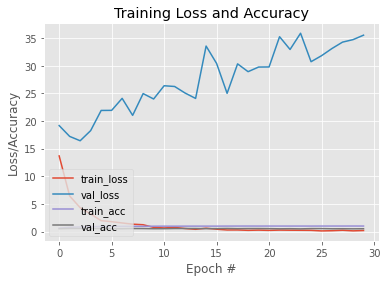

In [216]:
import matplotlib.pyplot as plt
def plot_training(H):
# construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history.history["loss"], label="train_loss")
    plt.plot(H.history.history["val_loss"], label="val_loss")
    plt.plot(H.history.history["acc"], label="train_acc")
    plt.plot(H.history.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
plot_training(model)

In [151]:
# Modify paths as per your need
test_path = "<REPLACE-PATH>\\Kinship Recognition Starter dh2868_al4008\\test\\"

# model = model3()
# model.load_weights("C:\\Users\\DavidHeagy\\Desktop\\Kinship Recognition Starter dh2868_al4008-20210809T164504Z-001\\Kinship Recognition Starter dh2868_al4008\\new_face_2021-08-15 03:31:50.410707.h5")

submission = pd.read_csv(r'<REPLACE-PATH>\Kinship Recognition Starter dh2868_al4008\test_ds.csv')
predictions = []

for i in range(0, len(submission.p1.values), 32):
    print(i)
    X1 = submission.p1.values[i:i+32]
    X1_vgg = np.array([read_img_vgg(test_path + x) for x in X1])
    X1_fn = np.array([read_img_fn(test_path + x) for x in X1])
    X2 = submission.p2.values[i:i+32]
    X2_vgg = np.array([read_img_vgg(test_path + x) for x in X2])
    X2_fn = np.array([read_img_fn(test_path + x) for x in X2])
    pred = model.predict([X1_vgg, X2_vgg, X1_fn, X2_fn]).ravel().tolist()
    predictions += pred

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976


In [152]:
p = 0
n  = 0
for i in predictions:
    if i>=.5:
        p+=1
    else:
        n+=1
print(p,n)

1697 1303


In [153]:
# postprocessing used 
epsilon = .0001
delta = .001
n = len(predictions)
while True:
    pos_count = np.sum(np.rint(predictions))
    prop_pos = pos_count / n
    print(prop_pos)
    
    if prop_pos <= 0.5 + delta and prop_pos >= 0.5 -delta:
        break
        
    for i in range(n):
        if prop_pos < 0.5: # 0 most popular class
            if predictions[i] < 0.5:
                predictions[i] += epsilon
        else:
            if predictions[i] >= 0.5:
                predictions[i] -=epsilon
    

0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5656666666666667
0.5653333333333334
0.5653333333333334
0.5653333333333334
0.565
0.5646666666666667
0.5643333333333334
0.5643333333333334
0.564
0.564
0.564
0.564
0.564
0.564
0.564
0.564
0.5636666666666666
0.5636666666666666
0.5633333333333334
0.5633333333333334
0.5626666666666666
0.5626666666666666
0.5623333333333334
0.5623333333333334
0.5623333333333334
0.5623333333333334
0.5623333333333334
0.562
0.562
0.562
0.562
0.562
0.562
0.562
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.5616666666666666
0.561666666

0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5226666666666666
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.5223333333333333
0.522
0.5213333333333333
0.5213333333333333
0.5213333333333333
0.5213333333333333
0.5213333333333333
0.5213333333333333
0.5213333333333333
0.521
0.521
0.521
0.521
0.5206666666666667
0.5206666666666667
0.5206666666666667
0.5206666666666667
0.5206666666666667
0.5206666666666667
0.5206666666666667
0

In [154]:

for i,v in enumerate(predictions):
    if v>=.5:
        predictions[i]=1
    else:
        predictions[i]=0
# print(p,n)

In [155]:
predictions

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,


In [157]:
p = 0
n  = 0
for i in predictions:
    if i>=.5:
        p+=1
    else:
        n+=1
print(p,n)

1503 1497


In [158]:
d = {'index': np.arange(0, 3000, 1), 'label':predictions}
submissionfile = pd.DataFrame(data=d)
submissionfile = submissionfile.round()

In [159]:
submissionfile.astype("int64").to_csv(r"<REPLACE-PATH>\Kinship Recognition Starter dh2868_al4008\dh2868_al4008_{}.csv".format(4), index=False)

In [ ]:
# EVERYTHING BELOW IS IRRELEVANT

Define a data generator. Here our data generator will generate a batch of examples which will be used by our model in training. It will generate two images, one for each in the pair as well as a label associated with it.

In [ ]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size)
        
        # All the samples are taken from train_ds.csv, labels are in the labels column
        labels = []
        for tup in batch_tuples:
            labels.append(tup[2])

        X1 = [x[0] for x in batch_tuples]
        X1 = np.array([read_img(train_folders_path + x) for x in X1])

        X2 = [x[1] for x in batch_tuples]
        X2 = np.array([read_img(train_folders_path + x) for x in X2])

        yield [X1, X2], np.array(labels)

Here is an ensemble model built with two resnet-50 architectures, pre-trained, with which we can apply transfer leraning on. This model achieves the baseline and the goal is to expand on this work. There have been papers exploring different architectures as well as introducing BatchNormalization among many other techniques to improve how well the model recognizes kinship between two faces.

In [ ]:
def baseline_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x1 = BatchNormalization()(x1)
    x2 = base_model(input_2)
    x2 = BatchNormalization()(x2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x = Multiply()([x1, x2])

    x = Concatenate(axis=-1)([x, x3])

    x = Dense(100, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.applications import resnet
def new_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace( include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x1 = BatchNormalization()(x1)
    x2 = base_model(input_2)
    x2 = BatchNormalization()(x2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x = Multiply()([x1, x2])

    x = Concatenate(axis=-1)([x, x3])
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.0001))

    model.summary()

    return model

Save the best model to your drive after each training epoch so that you can come back to it. ReduceLROnPlateau reduces the learning rate when a metric has stopped improving, in this case the validation accuracy. 

In [ ]:
import datetime 

date_t = datetime.datetime.now()

# file_path = "/content/drive/MyDrive/Kinship Recognition Starter dh2868_al4008/vgg_face.h5"
new_file_path = r"<REPLACE-PATH>\Kinship Recognition Starter dh2868_al4008\new_face_{}.h5".format(date_t)
checkpoint = ModelCheckpoint(new_file_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model()


In [ ]:
# Modify paths as per your need
test_path = "/content/drive/MyDrive/Kinship Recognition Starter dh2868_al4008/test/"

# model = baseline_model()
# model.load_weights("/gdrive/MyDrive/vgg_face.h5")

submission = pd.read_csv('/content/drive/MyDrive/Kinship Recognition Starter dh2868_al4008/test_ds.csv')
predictions = []

for i in range(0, len(submission.p1.values), 32):
    print(i)
    X1 = submission.p1.values[i:i+32]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = submission.p2.values[i:i+32]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

The final predictions will need to be rounded: EG 0.01 rounded to 0 and 0.78 rounded to 1. The simple .round() function is sufficient as below.

In [ ]:
d = {'index': np.arange(0, 3000, 1), 'label':predictions}
submissionfile = pd.DataFrame(data=d)
submissionfile = submissionfile.round()

In [ ]:
submissionfile.astype("int64").to_csv("/content/drive/MyDrive/Kinship Recognition Starter dh2868_al4008/dh2868_al4008_{}.csv".format(date_t), index=False)

At this point, download the CSV and submit it on Kaggle to score your predictions.
